## How to Construct and Interpret Strength-depth Profiles

In this notebook, I walk through the process of constructing a 
strength-depth profile for an oceanic plate and for a continental plate.

The steps required to define a strength-depth profile are:    
* Define a thermal profile as a function of depth.
* Define a pressure profile as a function of depth.
* Define failure criterion for brittle deformation.
* Define a viscous flow-law for plastic deformation.
* Define a strain-rate. 

The strength is then defined by the deformation mechanism (e.g., brittle, viscous) that gives the minimum strength as a function of depth/pressure.

Magali Billen

University of California, Davis

Department of Earth and Planetary Science

October 2019

### Step 1: Define a thermal profile

For the thermal profile, we will use the solution to cooling of a half-space, 
$$ T(z,t) = T_s + (T_s-T_m)erf(\frac{z}{2\sqrt{\kappa t}}) $$
where $z$ is depth, $t$ is age, $T_s$ and $T_m$ are the temperature at the surface and in the mantle, and $\kappa$ is the thermal diffusivity.

This choice for the thermal profile is appropriate for oceanic lithosphere less than 80-100 my. For older oceanic lithospheres, other processes (small-scale convection) may cause removal of the base of lithosphere, which limits further cooling.  For continental lithosphere, radiogenic heating is ignored, so choice of cooling age is not directly related to the age of the continent.   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Constants for converting units
yr2sec = 60*60*24*365.25  # sec/year
my2yr = 1e6  # year/million years
km2m = 1000  # m/km

# Physical constants
kappa = 1e-6  # thermal diffusivity (m^2/s)
T_s = 0  # surface temperature (C)
T_m = 1350 # mantle temperature (C)
t_my = 100  # plate age (my)

z_km = np.arange(0.01,155,5)  # depth (km)

t = t_my*my2yr*yr2sec  # age (sec)
z = z_km*km2m
T = T_s + (T_m - T_s)*erf(z/(2*np.sqrt(kappa*t)))

fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.plot(T,z_km)
ax1.set_ylim(150,0)
ax1.grid(True)
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Depth (km)')

Text(0,0.5,'Depth (km)')

### Step 2: Define a pressure profile

We will approximate the pressure as a function of depth from the compressibility using Equation 4-321 (Turcotte and Schubert, Geodynamics 2nd edition, p. 190). 

$$ P(z) = \frac{-1}{\beta}ln(1 - \rho_m g \beta z) $$

where $\beta$ is the compressibility, $\rho_m$ is the reference density at mantle temperature, and $g$ is the gravitational acceleration.

Note that at shallow depth (upper mantle), this equation gives the same pressure as simply calculating the lithostatic pressure ($P_{lith} = \rho_m g z$). I tend to use the compressibility equation because I also calculate viscosities in the lower mantle.

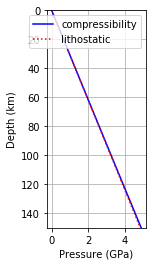

In [2]:
# Constants for converting units
pa2gpa = 1e9  # pascals per giga-pascal

# Physical constants
beta = 4.3e-12  # compressiblity (1/Pa)
rho_m = 3300    # reference density (kg/m^3)
g = 9.81        # gravitational acceleration (m/s^2)
P = (-1/beta)*np.log(1 - rho_m*g*beta*z)  # pressure (Pa)
Pgpa = P/pa2gpa  # GPa

Plith = rho_m*g*z
Plithgpa = Plith/pa2gpa

fig = plt.figure()
ax2 = fig.add_subplot(1,3,2)
ax2.plot(Pgpa,z_km,color='blue',label='compressibility')
ax2.plot(Plithgpa,z_km,color='red',linestyle='dotted',label='lithostatic')
ax2.set_ylim(150,0)
ax2.grid(True)
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Depth (km)')
ax2.legend()

### Step 3: Define brittle failure criterion

The failure of the brittle crust and lithosphere is controlled by frictional and/or fracture strength. For strength-depth profiles, the frictional strength is typically used with the assumption that pre-existing faults limit the effective brittle strength. Therefore, we can use the empirically-defined Byerlee's law for fricational sliding to estimate the brittle strength of the crust and lithosphere:

$\tau = 0.85\sigma_n$, for $\sigma_n < 200$ MPa

$\tau = 60 + 0.6\sigma_n$, for $200 < \sigma_n < 1700$ MPa

where $\tau$ is the shear strength, $\sigma_n$ is the normal stress on a fault (both in MPa). In using this to estimate plate strength, I will assume that $\sigma_n$ is given by the lithostatic pressure.

Note that this is the starting point for determining brittle strength, but this ignores the effect of pore fluid pressure on strength and does not account for the different strength of the crust in extension, compression or strike-slip environments ($\sigma_n$ depends on type of deformation). For more on these effects, see *Implications of hydrostatic pore pressures and high crustal strength for the deformation of intraplate lithosphere*, Mark D. Zoback and John Townend, Tectonophysics, **336**, 19-30, (2001). 



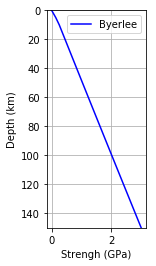

In [3]:
i = np.min(np.where(P>200e6)) # Index at which depth pressure equal 200 MPa

tau = np.zeros(np.size(P)) 
tau[0:i] = 0.85*P[0:i]      # from 0 to i
tau[i:] = 60e6 + 0.6*P[i:]  # from i to end

tau_gpa = tau/pa2gpa  # brittle strength in GPa

fig = plt.figure()
ax3 = fig.add_subplot(1,3,2)
ax3.plot(tau_gpa,z_km,color='blue',label='Byerlee')
ax3.set_ylim(150,0)
ax3.grid(True)
ax3.set_xlabel('Strengh (GPa)')
ax3.set_ylabel('Depth (km)')
ax3.legend()

### Step 4: define a viscous flow-law for plastic deformation

The lithosphere and mantle deform through viscous creep, however the specific flow-law (strain-rate vs. stress relationship) depends on many things (e.g., background stress, temperature, grain-size). For this example, we will assume that the viscous deformation is occurring through dislocation creep. At low temperature this will over-estimate the strength. Similarly, in shear zones/faults, grain-size can be significantly decreases such the diffusion creep becomes active. 

For oceanic lithosphere, we only need to define the viscous flow law for the mantle section because the thin ($\sim$7-8 km) crust will deform by brittle deformation. Because the mantle is 60% olivine, we use experimentally-derived flow-laws for olivine. The effect of pyroxene is thought to primarily affect maximum grain size through pinning (limiting the continued growth of larger grains).

The flow-law for deformation of olivine by dislocation creep is given by,
$$ \dot{\epsilon} = A \sigma^n \exp \left(-\frac{E + PV}{RT}\right) $$
where $ \dot{\epsilon}$ is the strain-rate, $\sigma$ is the stress, $A$ is the pre-exponential factor, $n$ is the stress exponent, $E$ is the activation energy, $V$ is the activation volume, $T$ is temperature and $R$ is the gas constant. 

This equation can be rearranged to give the stress (strength) in terms of strain-rate as,
$$ \sigma = \left(\frac{\dot{\epsilon}}{A}\right)^{1/n} \exp \left(\frac{E + PV}{nRT} \right) $$

I will use the values for the flow law *Rheology of the Upper Mantle and the Mantle Wedge: A View from the Experimentalists*, Greg Hirth and David Kohlstedt, Inside the Subduction Factory, Geophysical Monograph, **138** (2003)

/Users/billen/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


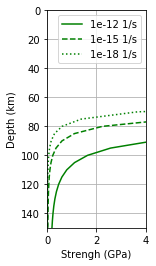

In [4]:
# I'll define a function to calculate the stress due to dislocation creep
# so I can easily calculate this for several strain-rates.

def stress_dislocation(edot,T,P):
    # Physical Constants
    R = 8.314 # J/mol*K

    # Flow-law parameters (Hirth and Kohlstedt, wet olivine, 2003)
    n = 3.5
    A = 90/np.power(1e6,n)  # for stress in Pa
    E = 480e3 # J/mol
    V = 11e-6  # m^3/mol
    
    sigma = np.power(edot/A,1/n)*np.exp((E + P*V)/(n*R*T))
    return sigma

edot = 1e-12
visc_stress1 = stress_dislocation(edot,T,P) # ignore overflow error
edot = 1e-15
visc_stress2 = stress_dislocation(edot,T,P)
edot = 1e-17
visc_stress3 = stress_dislocation(edot,T,P)

fig = plt.figure()
ax3 = fig.add_subplot(1,3,2)
ax3.plot(visc_stress1/pa2gpa,z_km,color='green',label='1e-12 1/s')
ax3.plot(visc_stress2/pa2gpa,z_km,color='green',linestyle='dashed',label='1e-15 1/s')
ax3.plot(visc_stress3/pa2gpa,z_km,color='green',linestyle='dotted',label='1e-18 1/s')
ax3.set_ylim(150,0)
ax3.set_xlim(0,4)
ax3.grid(True)
ax3.set_xlabel('Strengh (GPa)')
ax3.set_ylabel('Depth (km)')
ax3.legend()

### Strength-depth profile for Oceanic Plate

The plate will either fail brittlely or flow viscously, and whichever mechanism requires the lowest stress defines the strength of the plate. Therefore, the final step is to define the strength as the minimum stress predicted by the deformation mechanisms
$$ \sigma = min(\tau,\sigma) $$
In our example, we have just two mechanisms, but if more mechanisms are included, it is still the weakest mechanism that limits the strength.

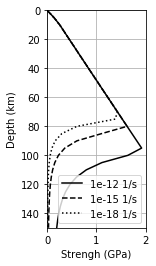

In [5]:
sigma1 = np.minimum(tau,visc_stress1)
sigma2 = np.minimum(tau,visc_stress2)
sigma3 = np.minimum(tau,visc_stress3)

fig = plt.figure()
ax4 = fig.add_subplot(1,3,1)
ax4.plot(sigma1/pa2gpa,z_km,color='black',label='1e-12 1/s')
ax4.plot(sigma2/pa2gpa,z_km,color='black',linestyle='dashed',label='1e-15 1/s')
ax4.plot(sigma3/pa2gpa,z_km,color='black',linestyle='dotted',label='1e-18 1/s')
ax4.set_ylim(150,0)
ax4.set_xlim(0,2)
ax4.grid(True)
ax4.set_xlabel('Strengh (GPa)')
ax4.set_ylabel('Depth (km)')
ax4.legend()

### Interpreting a strength-depth profile

So, what does a strength-depth profile mean?  First, by constructing your own, you are now aware that a strength-depth profiles depends on several choices: the thermal profile, the strain-rate, what defines the brittle strength, what mechanisms are accommodating deformation.
In most cases, the strain-rate is a constant with depth, which may or may not be true in the real tectonic setting. When pore pressure is included, it is also commonly assumed to be constant with depth.

Given this understanding, the strength-depth profile is a useful indicator of what part of the plate provides the physical strength, or leads to the plate-like behavior. However, its important to realize that as soon as the plate is subject to a change in tectonic stress (starts to extend or compress or shear) the conditions will change... including temperature, and strain-rate, and possibly the deformation mechanism. So, it does not tell you how deformation will unfold, or which part of the plate will deformation the most or least. 